In [1]:
%load_ext autoreload
%autoreload 2

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

from bon.utils import utils
from bon.utils.plot_utils import set_plot_style
from bon.utils.power_law_simple import fit_power_law
from bon.utils.powerlaw_plot_utils import adjust_color, plot_fitted_asr, plot_mean_and_std
from bon.utils.shotgun_utils import calculate_asr_trajectories, process_powerlaw_data

warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
color_palette = set_plot_style()

def convert_to_percentages(data):
    return [[value * 100 for value in sublist] for sublist in data]

# Load data

In [10]:
direct_requests =  Path("../data/direct_request.jsonl")
df_direct = utils.load_jsonl_df(direct_requests)

In [11]:
def get_powerlaw_data(models, shotgun_type="text", num_steps=8, train_split=1000, num_concurrent_k=10):
    dfs = {}
    asrs = {}
    train_asrs = {}
    perc_asrs = {}

    for model_name, model_path in models.items():

        print(f"\nProcessing {model_name}")
                
        dfs[model_name] = process_powerlaw_data(
            model_path, df_direct, 
            "direct_request_search_steps.jsonl",
            num_steps, num_concurrent_k, 159, shotgun_type=shotgun_type, 
            pad_to_n_steps=False, overwrite=False,
        )
        
        asrs[model_name] = calculate_asr_trajectories(
            dfs[model_name], model_path, num_repeats=10
        )
        train_asrs[model_name] = calculate_asr_trajectories(
            dfs[model_name], model_path, num_repeats=10, train_num_samples=train_split, num_samples=train_split
        )
        
        perc_asrs[model_name] = convert_to_percentages(asrs[model_name])
    
    experiments = {
        model_name: (perc_asrs[model_name], asrs[model_name], train_asrs[model_name], train_asrs[model_name], dfs[model_name])
        for model_name in models.keys()
    }
    
    return experiments


In [13]:
root_dir_text = Path("../exp/bon/text")
# root_dir_audio = Path("./exp/bon/audio")
# root_dir_image = Path("./exp/bon/image")

text_models = {
    # "GPT-4o-Mini": root_dir_text / "gpt-4o-mini",
    "Llama-3-8B-Instruct-RR": root_dir_text / "Llama-3-8B-Instruct-RR"
}

# audio_models = {
#     "Gemini Flash": root_dir_audio / "gemini-1.5-flash-001",
# }
# 
# vision_models = {
#     "GPT-4o-Mini": root_dir_image / "gpt-4o-mini",
# }

text_experiments = get_powerlaw_data(text_models, shotgun_type="text", num_steps=8)
# vision_experiments = get_powerlaw_data(vision_models, shotgun_type="image", num_steps=8)
# audio_experiments = get_powerlaw_data(audio_models, shotgun_type="audio", num_steps=8)



Processing Llama-3-8B-Instruct-RR


Saving powerlaw data to ../exp/bon/text/Llama-3-8B-Instruct-RR/powerlaw_8.jsonl
Returning powerlaw data with 810 records


In [18]:
color_mapping = {
    "Claude 3 Opus": adjust_color(color_palette[0], 0.5),
    "Claude 3.5 Sonnet": adjust_color(color_palette[0], -0.1),
    "GPT-4o": adjust_color(color_palette[2], -0.1),
    "GPT-4o-Mini": adjust_color(color_palette[2], 0.5),
    "Gemini Flash": adjust_color(color_palette[3], 0.5),
    "Gemini Pro": adjust_color(color_palette[3], -0.1),
    "Llama3 8B": color_palette[6],
    "Circuit Breaking": color_palette[4],
    "DiVA": color_palette[8],
    "Cygnet": color_palette[5],
    "Cygnet w/ system prompt": color_palette[5],
    "Llama-3-8B-Instruct-RR": color_palette[5]
}

# Mega Figure 1 Simplified

Fitting Llama-3-8B-Instruct-RR, Text, final ASR: 18.18%, num steps: 80


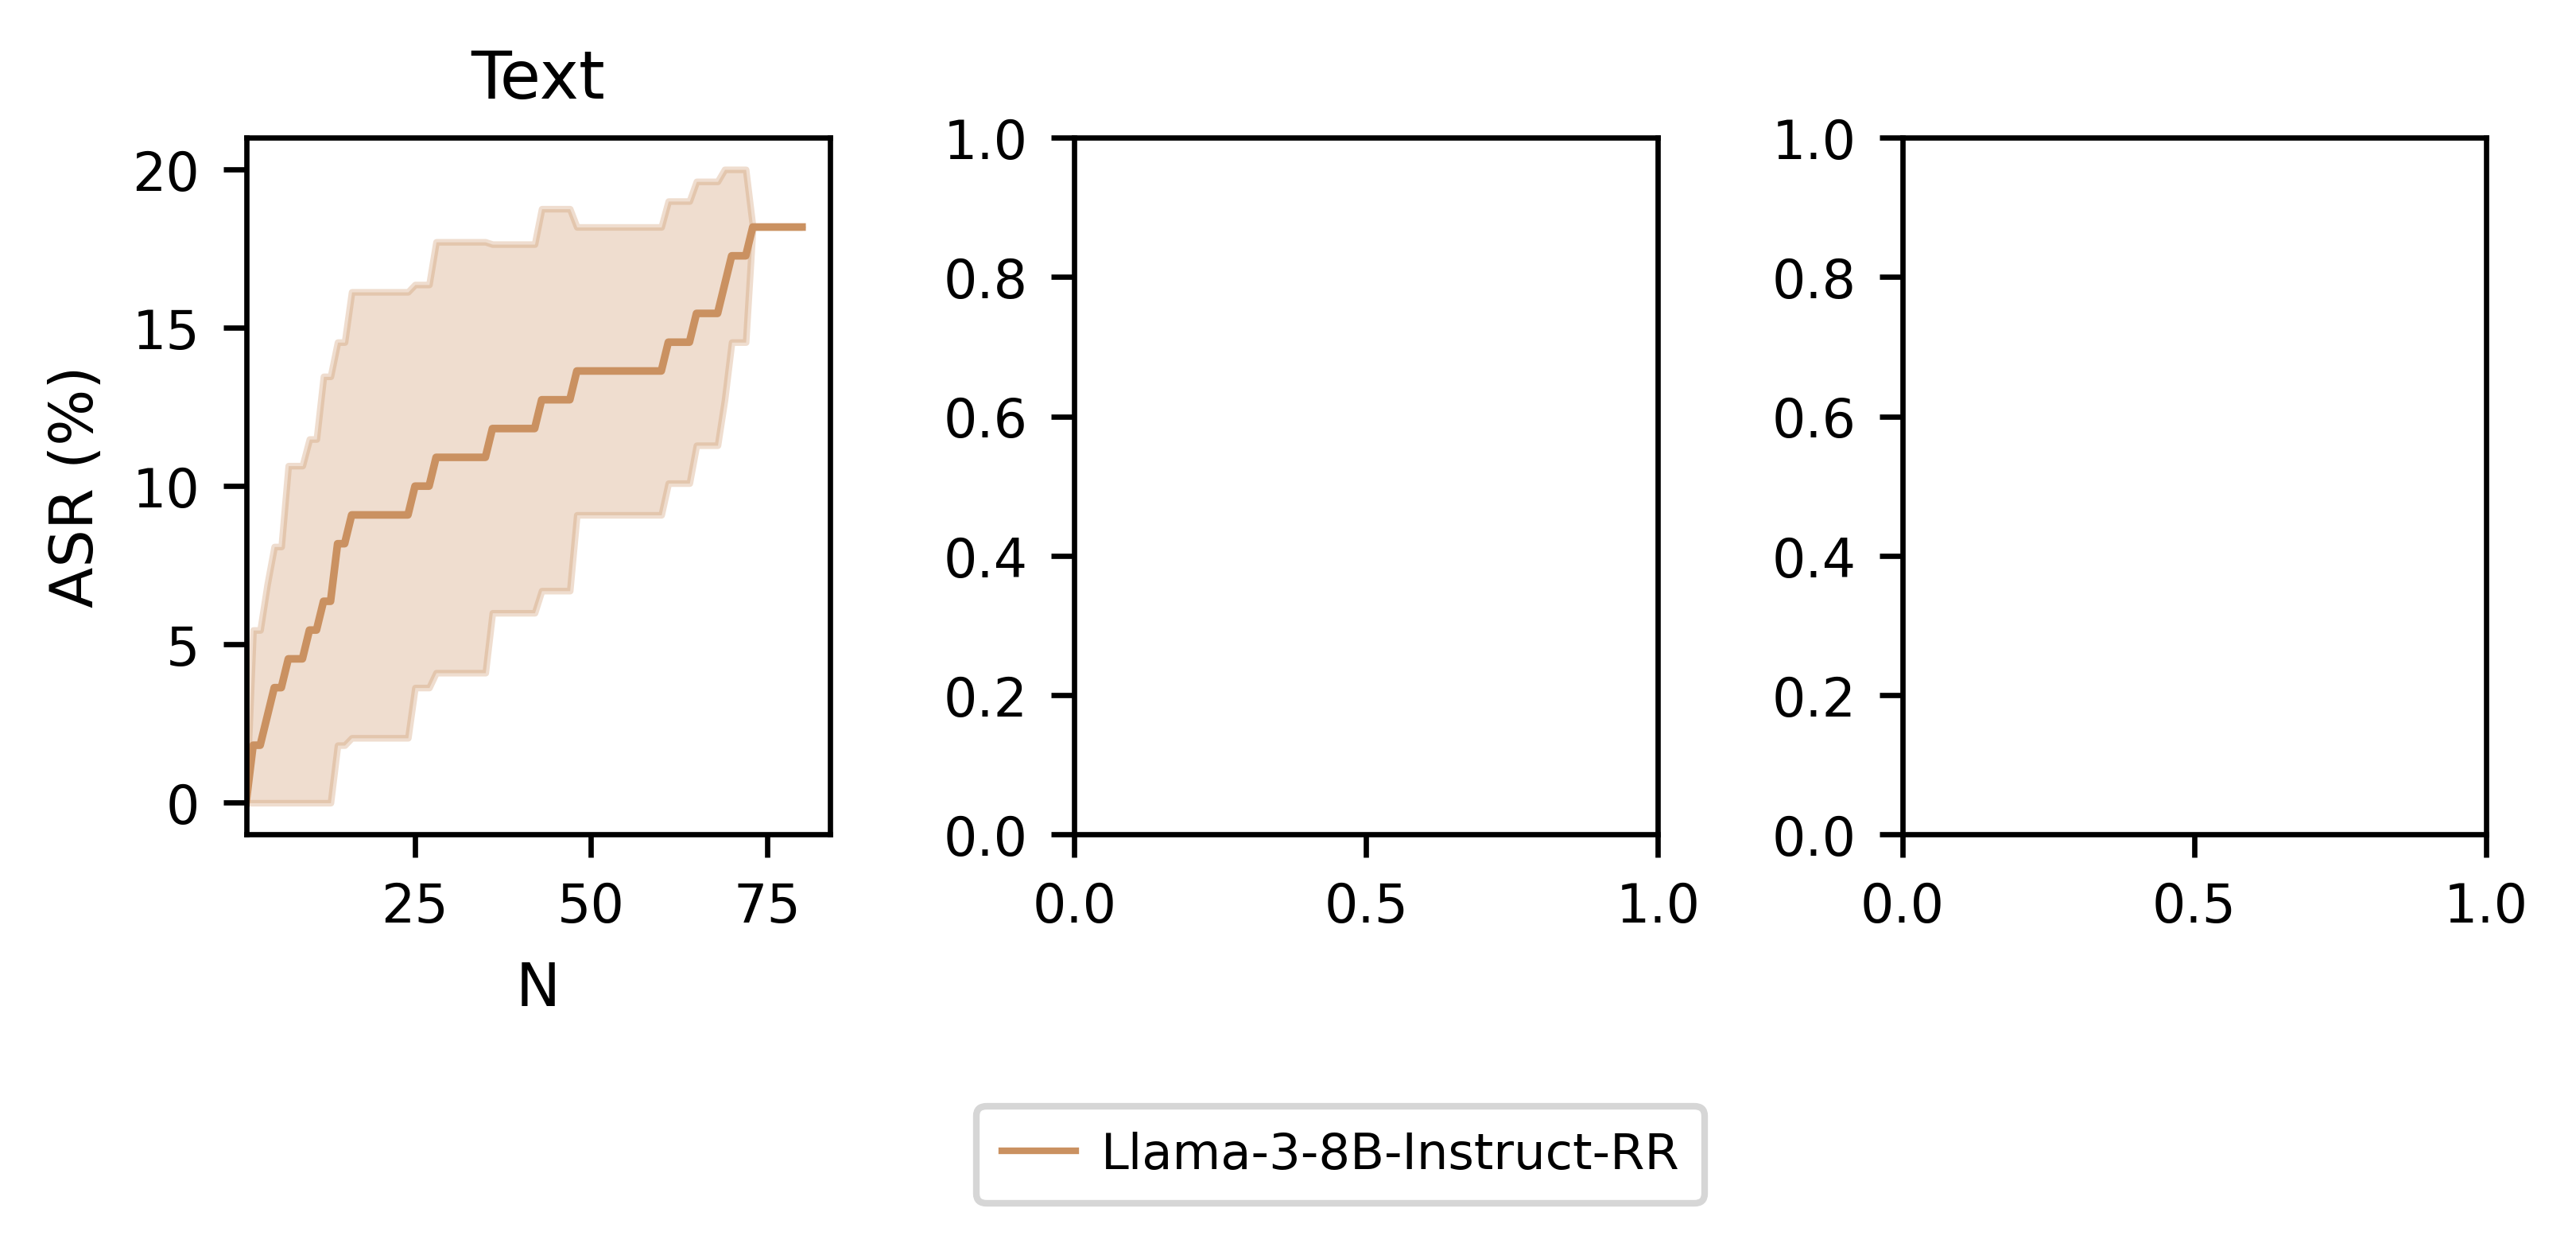

18.181818181818183


In [19]:

# models_to_plot = ["GPT-4o-Mini", "Gemini Flash"]
models_to_plot = ["Llama-3-8B-Instruct-RR"]

fig, axes = plt.subplots(1, 3, figsize=(5.5, 2.5), dpi=600)

all_asrs = []
for i, (modality_exp, modality_name) in enumerate(zip([text_experiments], ["Text"])):
    for j, (exp_name, asrs) in enumerate(modality_exp.items()):
        if exp_name not in models_to_plot:
            continue

        # Prepare the data
        prop_asr = np.array(asrs[1])
        prop_asr_mean = np.mean(prop_asr, axis=0)
        prop_asr_std = np.std(prop_asr, axis=0)

        perc_asr = np.array(asrs[0])
        perc_asr_mean = np.mean(perc_asr, axis=0)
        perc_asr_std = np.std(perc_asr, axis=0)

        steps = np.arange(1, len(prop_asr_mean)+1)
        color = color_mapping[exp_name]

        linewidth = 1.15

        # Plot regular fit in top row
        plot_mean_and_std(axes[i], perc_asr_mean, perc_asr_std, steps, exp_name="", log_scale_x=False, log_scale_y=False, color=color, plot_std_err=True, linewidth=linewidth)

        print(f"Fitting {exp_name}, {modality_name}, final ASR: {perc_asr_mean[-1]:.2f}%, num steps: {len(steps)}")
        all_asrs.append(perc_asr_mean[-1])

    
    # Set properties for regular fit (top row)
    ax = axes[i]
    if i == 0:
        ax.set_ylabel("ASR (%)")
    else:
        ax.set_ylabel("")
    ax.set_title(modality_name)
    ax.tick_params(axis='both', which='major', labelsize=8)
    # ax.set_yticks([0, 20, 40, 60, 80, 100], [0, 20, 40, 60, 80, 100])
    # if i != 0:
    #     ax.set_xticks([0, 2000, 4000, 6000], ["0", "2k", "4k", "6k"])
    # else:
    #     ax.set_xticks([0, 2500, 5000, 7500, 10000], [0, "2.5k", "5k", "7.5k", "10k"])
    # ax.set_xlim(right=7200 if i > 0 else 10000)
    # ax.set_ylim(0, 102)
    ax.set_xlabel("N")


plt.tight_layout()

# Add legend elements
legend_elements = []
for exp_name, color in color_mapping.items():
    if exp_name in models_to_plot:
        legend_elements.append(Line2D([0], [0], color=color, linestyle="-", lw=1, label=f"{exp_name}"))

# Create a single legend below the plots
fig.legend(handles=legend_elements, 
           loc='lower center', 
           ncol=4, 
           bbox_to_anchor=(0.52, -0.05),
           columnspacing=1,
           handlelength=1.5,
           handletextpad=0.5,
           borderpad=0.5,
           labelspacing=0.5)

plt.subplots_adjust(bottom=0.28)  # Increased bottom margin
plt.show()
plt.close()

print(np.mean(all_asrs))

# Fitting Power Law

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(5.5, 2.5), dpi=600, sharey=True)

models_to_plot = ["GPT-4o-Mini", "Gemini Flash"]

for i, (modality_exp, modality_name) in enumerate(zip([text_experiments, vision_experiments, audio_experiments], ["Text", "Vision", "Audio"])):
    ax = axes[i]
    for j, (exp_name, asrs) in enumerate(modality_exp.items()):
        if exp_name not in models_to_plot:
            continue
        print(f"Fitting {exp_name}")

        # Prepare the data
        prop_asr = np.array(asrs[1])
        prop_asr_mean = np.mean(prop_asr, axis=0)
        prop_asr_std = np.std(prop_asr, axis=0)

        perc_asr = np.array(asrs[0])
        perc_asr_mean = np.mean(perc_asr, axis=0)
        perc_asr_std = np.std(perc_asr, axis=0)

        steps = np.arange(1, len(prop_asr_mean)+1)
        color = color_mapping[exp_name]

        linewidth = 1.15
        
        # Plot log space fit
        plot_mean_and_std(ax, prop_asr_mean, prop_asr_std, steps, exp_name="", log_scale_x=True, log_scale_y=True, color=color, plot_std_err=True, linewidth=linewidth, std_scale_factor=1, use_line=False)

        # Fit the model
        try:
            params = fit_power_law(x=steps, y=prop_asr, fit_type="linear_log_spacing", skip_first_points=5)
        except Exception:
            params = fit_power_law(x=steps, y=prop_asr, fit_type="linear", skip_first_points=5)
        
        # Plot fitted ASR for log space fit
        plot_fitted_asr(ax, steps, params, color=color, exp_name="", log_scale_x=True, log_scale_y=True,linewidth=linewidth)

        print(f"{exp_name}, {modality_name}, {params}")

    # Create second y-axis for ASR percentage
    if i == 2:
        ax2 = ax.twinx()
        ax2.set_yscale('log')
        # ax2.set_ylim(0.03, 5)

        # Set ticks for both axes
        yticks = ax.get_yticks()
        ax.set_yticklabels([f"{y:.1f}" for y in yticks])
        ax2.set_yticklabels([f"{np.exp(-y)*100:.0f}%" for y in yticks])

        # Set titles and labels
        ax2.set_ylabel("ASR (%)")
        ax2.tick_params(axis='both', which='major')
        

    ax.set_title(modality_name)
    if i == 0:
        ax.set_ylabel("-log(ASR)")
    ax.tick_params(axis='both', which='major', labelsize=8)
    # ax.set_yticks([0.01, 0.1, 1], [0.01, 0.1, 1])
    if i == 1:
        ax.set_xlabel("N")
    # ax.set_xlim(left=10)
    # ax.set_xlim(right=7200)
    
    ax.set_ylim(0.03, 5)


plt.tight_layout()

# Add legend elements
legend_elements = []
for exp_name, color in color_mapping.items():
    if exp_name in models_to_plot:
        legend_elements.append(Line2D([0], [0], color=color, linestyle="-", lw=1, label=f"{exp_name}"))

# Create a single legend below the plots
fig.legend(handles=legend_elements, 
           loc='lower center', 
           ncol=4, 
           bbox_to_anchor=(0.52, -0.05),  # Moved up slightly
           columnspacing=1,
           handlelength=1.5,
           handletextpad=0.5,
           borderpad=0.5,
           labelspacing=0.5)  # Reduced font size slightly


plt.subplots_adjust(bottom=0.28)  # Increased bottom margin
plt.show()
plt.close()